## PUI 2016 HOMEWORK 9, ASSIGNMENT 1
#### Ian Wright, iw453
#### November 2016

In [186]:
#standard
import pandas as pd
import numpy as np
import os

#plotting
import matplotlib.pylab as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
%matplotlib inline

#stats
import scipy.stats as stats
import statsmodels.formula.api as sm

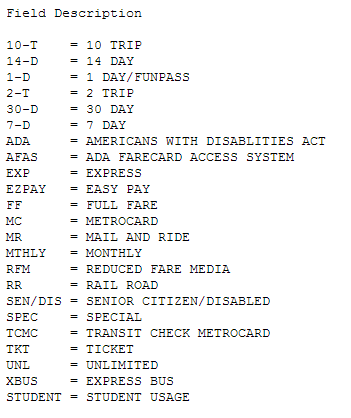

In [324]:
# reference image for MTA card types
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [81]:
# get MTA swipe data from PUIDATA
puidata = os.getenv('PUIDATA')
mta = np.load(puidata + '/MTA_Fare.npy')

In [82]:
# 600 stations
# 23 card types
# 194 time series observations
mta.shape

(600, 23, 194)

Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014.

In [83]:
# create a list of 23 card types that correspond to our data array's 2nd dimension
card_type = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
len(card_type)

23

In [84]:
# create a datetime index starting on 05/21/2010 at a weekly frequency for 194 weeks
dates = pd.date_range(start='05/21/2010', periods=194, freq='W-FRI').tolist()
print dates[0]
print dates[-1]

2010-05-21 00:00:00
2014-01-31 00:00:00


In [88]:
# we know that NaN values are represented as -1, so let's change them back to NaN
mta = np.where(mta == -1, np.full(mta.shape, np.nan), mta)

### Task 1: 
#### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [94]:
# I will try to detect events in fully aggregated data
# np.nansum() only sums over one axis at a time, so we nest two calls
mta_aggall = np.nansum(np.nansum(mta, axis=0), axis=0)

In [143]:
# determine 3-sigma event thresholds on aggregate data
print 'aggregate standard dev:', mta_aggall.std()
agg_thresholds = [np.round(mta_aggall.mean() - 3 * mta_aggall.std(), 1), 
                 np.round(mta_aggall.mean() + 3 * mta_aggall.std(), 1)]
print '3-sigma lower event threshold:', agg_thresholds[0]
print '3-sigma upper event threshold:', agg_thresholds[1]

aggregate standard dev: 2983960.4217
3-sigma lower event threshold: 20829468.6
3-sigma upper event threshold: 38733231.1


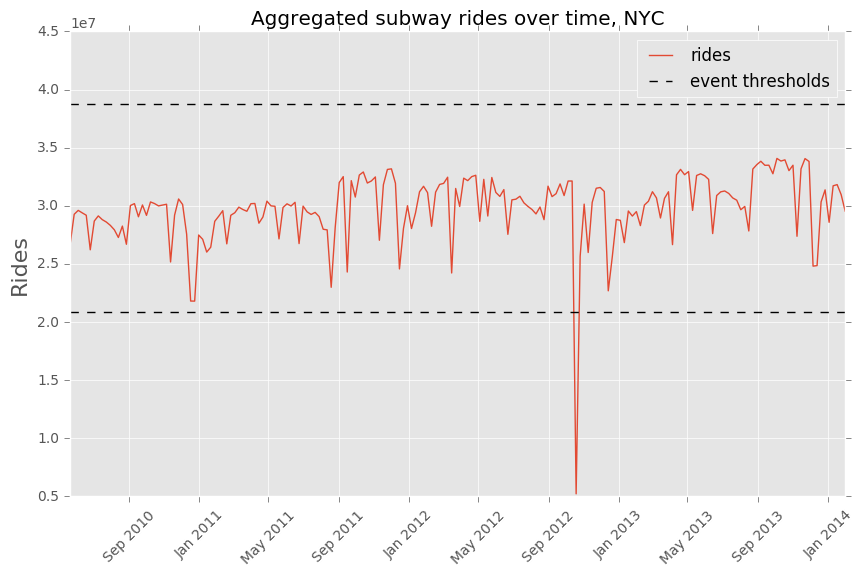

In [147]:
# first, look for major events by visual inspection
aggall_df = pd.DataFrame(data=mta_aggall, index=dates, columns=['rides'])

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ax.plot(aggall_df, label='rides')

# plot the reference lines for lower and upper thresholds
ax.plot([min(aggall_df.index), max(aggall_df.index)], 
        [agg_thresholds[0], agg_thresholds[0]], 'k--', label='event thresholds')
ax.plot([min(aggall_df.index), max(aggall_df.index)], 
        [agg_thresholds[1], agg_thresholds[1]], 'k--')
ax.set_title('Aggregated subway rides over time, NYC')  
ax.set_ylabel('Rides', fontsize=16)
ax.set_ylim(0.5e7, 4.5e7)

plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend()
plt.show()

##### FIGURE 1: MTA subway rides aggregated across station and card type. Upper and lower 3-sigma thresholds are plotted too, and it is clear that only one event crossed the 3-sigma event threshold in the considered time frame. The event appears to take place around October 2012, but closer inspection is neeed.

In [146]:
# what is the exact week in which this event occurred
aggall_df[aggall_df['rides'] < agg_thresholds[0]]

,rides
2012-10-19,5218686.0


Hurricane Sandy started on October 22, 2012; this would explain the extreme drop in subway ridership (due to closures and generally dangerous conditions outside).

### Task 2: 
#### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [149]:
# first, mean-aggregate the station-level data, so we're left with a (23, 194) array
mta_cards = np.nanmean(mta, axis=0)
mta_cards.shape

/Users/ian/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(23, 194)

In [154]:
# convert to a dataframe
cards_df = pd.DataFrame(data=np.transpose(mta_cards), index=dates, columns=card_type)

In [202]:
# remove the single 3-sigma event for cleaner data
cards_df.loc['2012-10-19',:] = np.nan

# smooth data by taking a 4-wk average
smooth_cards_df = pd.DataFrame(index=dates, columns=card_type)
for col in cards_df.columns:
    smooth_cards_df.loc[:, col] = cards_df.loc[:, col].rolling(window=4, min_periods=3, center=True).mean()

In [243]:
# instead of inspecting visually, let's fit a line for each card type
# and look at both the slope coefficent, and corresponding error
# using R^2 to assess each line helps to distinguish between consistent growth and one-off structures in data

# regress over a set of ints to represent equally spaced time periods
time_as_ints = np.arange(len(smooth_cards_df))
card_stats = []
for col in smooth_cards_df.columns:
    mask = ~np.isnan(np.array(smooth_cards_df[col]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_as_ints[mask], smooth_cards_df[col][mask])
    card_stats.append({'card':col, 'slope':slope, 'r2':r_value**2})

# sort card types by line slope
card_stats_df = pd.DataFrame(card_stats).sort_values(by='slope')
print card_stats_df

     card        r2      slope
9      ez  0.423878  -5.516633
22   stud  0.019947  -5.331570
6     ada  0.015533  -3.132275
8     exp  0.417473  -2.727421
14    rfm  0.156904  -2.453217
13  month  0.792453  -0.631125
10     ff  0.025879  -0.119730
7    afas  0.444562  -0.103739
3      2t  0.009278  -0.034060
20  umlim  0.000336  -0.000569
21   xbus  0.557129   0.008145
19      t  0.018417   0.010279
4     30d  0.065125   0.044894
2      1d  0.146468   0.087911
11     mc  0.092501   0.304419
17   spec  0.547643   0.325977
16    sen  0.941606   0.738771
18   tcmc  0.617297   0.978485
15     rr  0.938624   1.349420
12     mr  0.583575   1.859734
1     14d  0.723681   2.400486
0     10t  0.181305  11.104395
5      7d  0.813028  23.099661


We're looking for slope coefficients that are dramatically high or low, and supported by reasonably strong R^2 values.

The '7d', '10t', and '14d' cards seem to have increased in popularity the most, while the 'ez', 'exp', and 'month' cards are contenders for the greatest steady decrease (but with weaker R2 values).

We'll plot all of these on a normalized graph to distinguish between true trends and structural features.

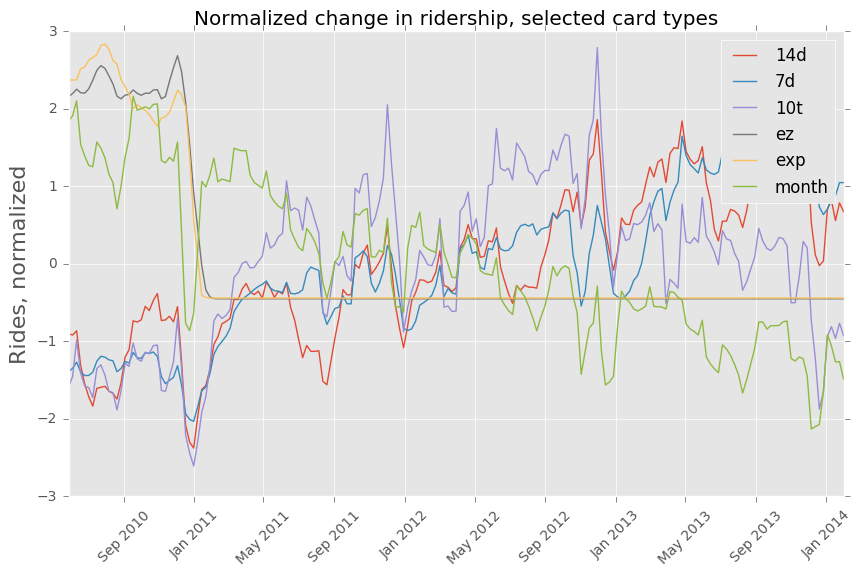

In [255]:
key_cards = ['14d', '7d', '10t', 'ez', 'exp', 'month']

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

for card in key_cards:
    norm = smooth_cards_df[card].map(lambda c: (c - np.mean(smooth_cards_df[card])) / np.std(smooth_cards_df[card]))
    ax.plot(norm, label=card)

ax.set_title('Normalized change in ridership, selected card types')  
ax.set_ylabel('Rides, normalized', fontsize=16)    
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend()
plt.show()

##### FIGURE 2: Smoothed and normalized growth or decay plots for the MTA card types that show high rates of change. We see that both 'ez' and 'exp' drop to zero early in the time series; these cards usage decline is not "real" and can be disregarded. 

Most extreme cases: the '7d' card increased steadily at ~23 rides/wk PER STATION (avg), while the 'month' card decreased by ~0.6 rides/wk PER STATION (avg).

### Task 3:
#### Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [318]:
# first, we aggregate our datacube along the 'card type' axis by summing
mta_stations = np.nansum(mta, axis=1)

# convert to dataframe with date indexes
stations_df = pd.DataFrame(data=np.transpose(mta_stations), index=dates)
stations_df.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
2010-05-21,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05-28,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06-04,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06-11,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06-18,162641.0,41509.0,7032.0,17589.0,20283.0,20909.0,14094.0,11944.0,10923.0,157628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


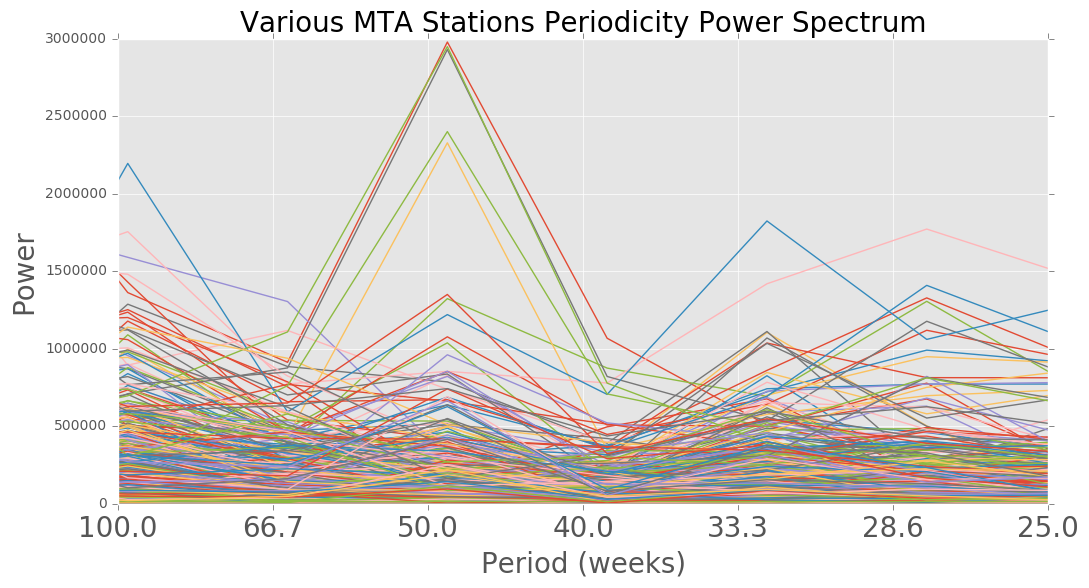

In [321]:
# create a periodicity power plot by means of a Fourier Transform
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

station_stats = []
for station in stations_df.columns:
    # plot the power values along a frequency axis
    mask = ~np.isnan(np.array(stations_df[station]))
    power = np.abs(np.fft.rfft(stations_df[station].values[mask]))
    N = len(stations_df[station][mask])
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (power[1:]))
    
    # for each station, we know that the power value closest to a 52wk period is at INDEX 4
    # so log those values for closer inspection later
    station_stats.append({'station':station, '52wk_power':power[4]})

# focus in on a tighter window that includes the 52 week mark
ax.set_xlim(1.0/100,1.0/25)
# for better readability, we'll show PERIOD rather than FREQUENCY on the x-axis
ax.set_xticklabels([np.round(1/f, 1) for f in ax.get_xticks()], fontsize=20)

plt.xlabel("Period (weeks)", fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.title("Various MTA Stations Periodicity Power Spectrum", fontsize=20)
plt.show()

##### FIGURE 3: Power spectrum for 600 different MTA stations across a range of frequencies (periods). We're looking for those stations that have show particularly high power around the 52 week period mark. Because there are so many stations being shown here, it's difficult to isolate the stations of interest.

In [317]:
# show the quantitative results for power around the 52 week mark
station_stats_df = pd.DataFrame(station_stats).sort_values(by='52wk_power', ascending=False)
print station_stats_df.head(10)

       52wk_power  station
0    2.980161e+06        0
194  2.950389e+06      194
150  2.931896e+06      150
327  2.402219e+06      327
32   2.329897e+06       32
539  1.351575e+06      539
19   1.324541e+06       19
169  1.221610e+06      169
56   1.078273e+06       56
54   1.039248e+06       54


We see that stations 0, 194, 150, 327, and 32 show particularly strong periodicity on a one year (52 week) cycle.

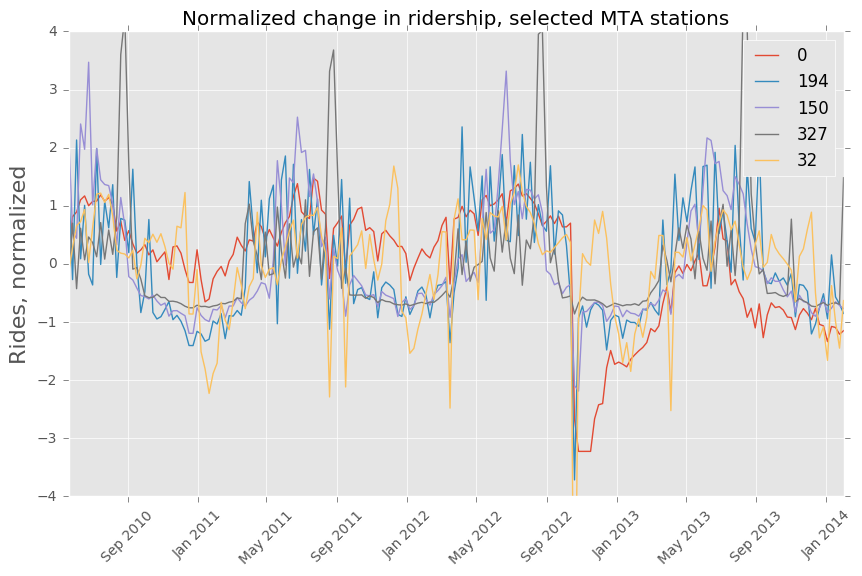

In [323]:
# now plot these 5 stations in real (not Fourier transformed) time to see the yearly cycle
key_stations = [0, 194, 150, 327, 32]

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

for station in key_stations:
    norm = stations_df[station].map(lambda s: (s - np.mean(stations_df[station])) / np.std(stations_df[station]))
    ax.plot(norm, label=station)

ax.set_title('Normalized change in ridership, selected MTA stations')  
ax.set_ylabel('Rides, normalized', fontsize=16)  
ax.set_ylim(-4, 4)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend()
plt.show()

##### FIGURE 4: Inspecting periodic trends for five MTA stations suspected of having strong annual periodicity. Clearly stations 0, 194, 150, 327 are most popular in the summer, while ridership slows down dramatically in the winter. Station 32 shows a similar pattern, but with a strong bump in ridership over the winter/Christmas holiday season. This station must service a tourist attraction that is popular both in the summer and at Christmas.